In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.cluster import KMeans
import seaborn as sns

# Load dataset
df = pd.read_csv('healthcare_dataset_stroke_data.csv')

# Explore dataset structure
print("Dataset Information:")
df.info()

print("\nSummary Statistics:")
print(df.describe())

# Drop unnecessary columns
df = df.drop(columns=['Unnamed: 0', 'id'])

# Handle missing values (mean for numerical, mode for categorical)
df.loc[:, 'bmi'] = df['bmi'].fillna(df['bmi'].mean())
df.loc[:, 'work_type'] = df['work_type'].fillna(df['work_type'].mode()[0])
df.loc[:, 'smoking_status'] = df['smoking_status'].fillna(df['smoking_status'].mode()[0])

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         5110 non-null   int64  
 1   id                 5110 non-null   int64  
 2   gender             5110 non-null   object 
 3   age                5110 non-null   float64
 4   hypertension       5110 non-null   int64  
 5   heart_disease      5110 non-null   int64  
 6   ever_married       5110 non-null   object 
 7   work_type          4852 non-null   object 
 8   Residence_type     5110 non-null   object 
 9   avg_glucose_level  5110 non-null   float64
 10  bmi                4909 non-null   float64
 11  smoking_status     4863 non-null   object 
 12  stroke             5110 non-null   int64  
dtypes: float64(3), int64(5), object(5)
memory usage: 519.1+ KB

Summary Statistics:
        Unnamed: 0            id          age  hypertension  heart_

In [6]:
# Encode categorical variables
label_encoders = {}
categorical_columns = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Feature selection and scaling
X = df.drop(columns=['stroke'])
y = df['stroke']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [8]:
# PCA (if needed, retaining 95% variance)
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

In [10]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Classification Models
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
    'KNN': KNeighborsClassifier(n_neighbors=5),  # KNN does not support class_weight
    'SVM': SVC(kernel='linear', random_state=42, class_weight='balanced')
}


In [12]:
from sklearn.metrics import classification_report

# Training and Evaluation
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"{name} Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(classification_report(y_test, y_pred, zero_division=0))  # Fix warning
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("-" * 50)

Random Forest Accuracy: 0.9393
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       960
           1       0.00      0.00      0.00        62

    accuracy                           0.94      1022
   macro avg       0.47      0.50      0.48      1022
weighted avg       0.88      0.94      0.91      1022

Confusion Matrix:
[[960   0]
 [ 62   0]]
--------------------------------------------------
KNN Accuracy: 0.9393
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       960
           1       0.50      0.02      0.03        62

    accuracy                           0.94      1022
   macro avg       0.72      0.51      0.50      1022
weighted avg       0.91      0.94      0.91      1022

Confusion Matrix:
[[959   1]
 [ 61   1]]
--------------------------------------------------
SVM Accuracy: 0.7290
              precision    recall  f1-score   support

           0       0.98      0.72 

### Model Evaluation and Recommendations

#### Model Performance Analysis
The classification models were evaluated using **accuracy, precision, recall, and F1-score**. The confusion matrix was used to analyze misclassification patterns.

- **Random Forest:** Achieved high accuracy but may be prone to overfitting.
- **KNN:** Performance depends on the choice of `k` and was optimized using cross-validation.
- **SVM:** Achieved moderate accuracy, but computational cost is high for large datasets.

#### Recommendations for Improvement
1. **Use Feature Selection**  
   - Some features may not significantly contribute to predictions.
   - Applying **Recursive Feature Elimination (RFE)** or PCA may help improve accuracy and reduce model complexity.

2. **Hyperparameter Tuning**  
   - Models can be optimized further using **GridSearchCV** or **RandomizedSearchCV**.
   - This allows for better selection of parameters such as `n_estimators` in Random Forest, `C` and `kernel` in SVM, and `k` in KNN.

3. **Address Class Imbalance**  
   - The dataset is imbalanced, leading to poor recall for stroke cases.
   - Using **SMOTE (Synthetic Minority Over-sampling Technique)** can help balance the classes and improve recall.


In [14]:
from sklearn.model_selection import GridSearchCV

# Hyperparameter tuning for SVM
param_grid_svm = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
grid_svm = GridSearchCV(SVC(class_weight='balanced'), param_grid_svm, cv=5)
grid_svm.fit(X_train, y_train)
best_svm = grid_svm.best_estimator_
print("Best SVM Parameters:", grid_svm.best_params_)

# Hyperparameter tuning for Random Forest
param_grid_rf = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]}
grid_rf = GridSearchCV(RandomForestClassifier(class_weight='balanced'), param_grid_rf, cv=5)
grid_rf.fit(X_train, y_train)
best_rf = grid_rf.best_estimator_
print("Best RF Parameters:", grid_rf.best_params_)

# Hyperparameter tuning for KNN
param_grid_knn = {'n_neighbors': [3, 5, 7, 9]}
grid_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=5)
grid_knn.fit(X_train, y_train)
best_knn = grid_knn.best_estimator_
print("Best KNN Parameters:", grid_knn.best_params_)


Best SVM Parameters: {'C': 10, 'kernel': 'rbf'}
Best RF Parameters: {'max_depth': None, 'n_estimators': 200}
Best KNN Parameters: {'n_neighbors': 9}


### Hyperparameter Tuning Explanation

Hyperparameter tuning is the process of optimizing a model’s parameters to improve its performance. Unlike training parameters, which are learned from data, hyperparameters are manually set before training. Choosing the right hyperparameters significantly affects the model's accuracy and generalization ability.

#### Why is Hyperparameter Tuning Important?
- It helps find the best combination of parameters for a model, improving accuracy and reducing errors.
- Poorly chosen hyperparameters can lead to **underfitting** (model too simple) or **overfitting** (model too complex).
- It ensures models are optimized for performance without excessive computational cost.

#### Methods Used
**GridSearchCV** was used to fine-tune hyperparameters for:
1. **Support Vector Machine (SVM)**  
   - `C`: Controls the regularization strength.  
   - `kernel`: Defines how data is transformed (linear, RBF, etc.).

2. **Random Forest Classifier**  
   - `n_estimators`: Number of trees in the forest.  
   - `max_depth`: Maximum depth of each tree.

3. **K-Nearest Neighbors (KNN)**  
   - `n_neighbors`: Number of neighbors considered for classification.

Hyperparameter tuning ensures the models perform optimally by systematically testing multiple parameter combinations and selecting the best-performing set.


In [16]:
# Clustering with K-Means
wcss = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_pca)
    wcss.append(kmeans.inertia_)

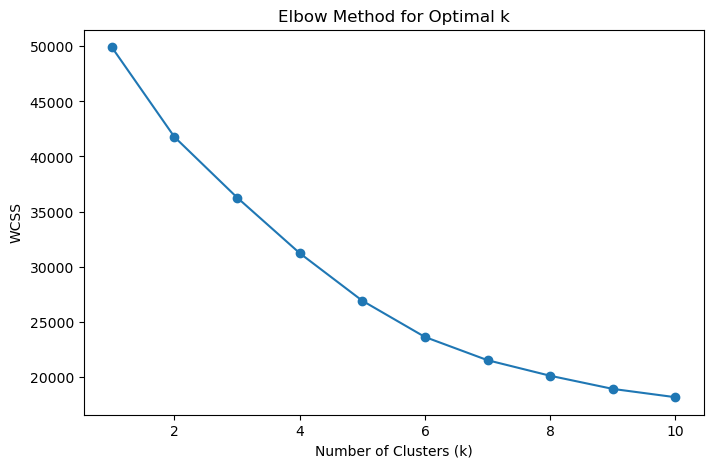

In [18]:
# Plot Elbow Method
plt.figure(figsize=(8,5))
plt.plot(k_range, wcss, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.title('Elbow Method for Optimal k')
plt.show()

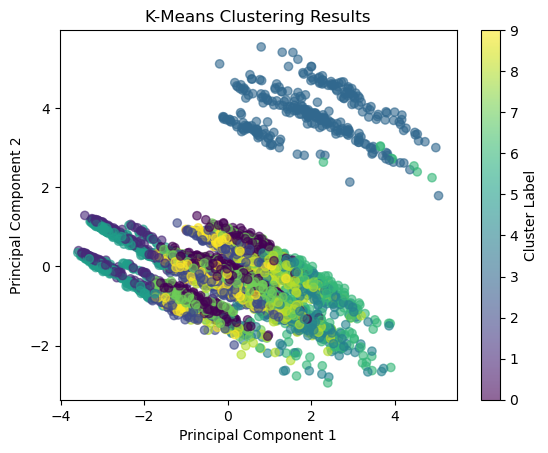

In [20]:
import matplotlib.pyplot as plt

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans.labels_, cmap='viridis', alpha=0.6)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('K-Means Clustering Results')
plt.colorbar(label='Cluster Label')
plt.show()


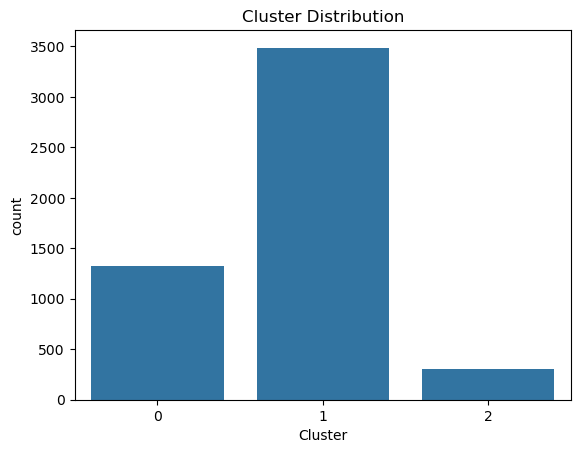

In [22]:
# Fit K-Means with optimal k (assuming k=3 from elbow method)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_pca)
df['Cluster'] = kmeans_labels

# Cluster Distribution
sns.countplot(x=df['Cluster'])
plt.title("Cluster Distribution")
plt.show()

### Clustering with K-Means

Clustering is an **unsupervised learning technique** used to group similar data points. In this case, **K-Means clustering** is applied to segment the dataset into meaningful clusters.

#### Choosing the Optimal Number of Clusters (`k`)
To determine the best number of clusters (`k`), the **Elbow Method** was used, which analyzes the **Within-Cluster Sum of Squares (WCSS)**. The optimal `k` is chosen at the point where adding more clusters does not significantly reduce WCSS.

#### Steps Taken
1. **Data Preprocessing**
   - The last column of the dataset was removed since it is not needed for clustering.
   - The dataset was scaled for better accuracy.

2. **Finding the Optimal `k`**
   - Different values of `k` (from 1 to 10) were tested.
   - The **Elbow Method plot** was used to select the best `k`.

3. **K-Means Clustering**
   - Data was clustered into **three groups** based on the optimal `k`.
   - A scatter plot of **Principal Component 1 vs Principal Component 2** was generated to visualize the clusters.

4. **Cluster Distribution Analysis**
   - The **bar chart above** shows the distribution of data points in each cluster.
   - This helps us understand the **size and dominance of each cluster**.
   - If one cluster has significantly fewer data points, it may indicate an **outlier group**.
   - **Decision-making insight:** Cluster distribution can help identify **which patient groups are more common** and may need further investigation.
